In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS10EC_d_t3_03.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS7EC_d_cz_08.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS10EC_d_f8_05.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS9EC_d_cz_04.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS5EC_d_c4_07.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS2EC_d_f4_01.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS15EC_d_p3_03.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS6EC_d_f7_09.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS14EC_d_cz_06.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS6EC_d_o1_02.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS3EC_d_f8_01.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS1EC_

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image

2024-05-22 23:04:41.635071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 23:04:41.635172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 23:04:41.796734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
folder_path = "/kaggle/input/data-egg/datset-egg/data_resized/Non_Responders"
image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"]  

# Get the list of all files in the folder
all_files = os.listdir(folder_path)

# Filter out only the image files
image_files = [file for file in all_files if any(file.lower().endswith(ext) for ext in image_extensions)]

# Count the number of images
num_images = len(image_files)

print(f"Number of images in {folder_path}: {num_images}")

Number of images in /kaggle/input/data-egg/datset-egg/data_resized/Non_Responders: 3249


In [4]:
# Define the base path
base_path = "/kaggle/input/data-egg/datset-egg/data_resized"

# Initialize lists to store paths and labels
paths = []
labels = []

# Traverse through the folders and collect paths and labels
for folder in ["Responders", "Non_Responders"]:
    folder_path = os.path.join(base_path, folder)
    
    # Iterate through files in the folder
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        
        # Append path and label to the lists
        paths.append(file_path)
        labels.append(folder)

# Create a DataFrame
df = pd.DataFrame({"path": paths, "label": labels})

# Display the DataFrame
df


,path,label
0,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
1,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
2,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
3,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
4,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
...,...,...
5410,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders
5411,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders
5412,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders
5413,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders


In [6]:
df["label"].value_counts()

label
Non_Responders    3249
Responders        2166
Name: count, dtype: int64

In [7]:
df.to_csv("EEG_Scalagram_Dataset.csv", index=False)

In [8]:
df = pd.read_csv("EEG_Scalagram_Dataset.csv")
df.head()

,path,label
0,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
1,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
2,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
3,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
4,/kaggle/input/data-egg/datset-egg/data_resized...,Responders


In [9]:
df["label"].value_counts()

label
Non_Responders    3249
Responders        2166
Name: count, dtype: int64

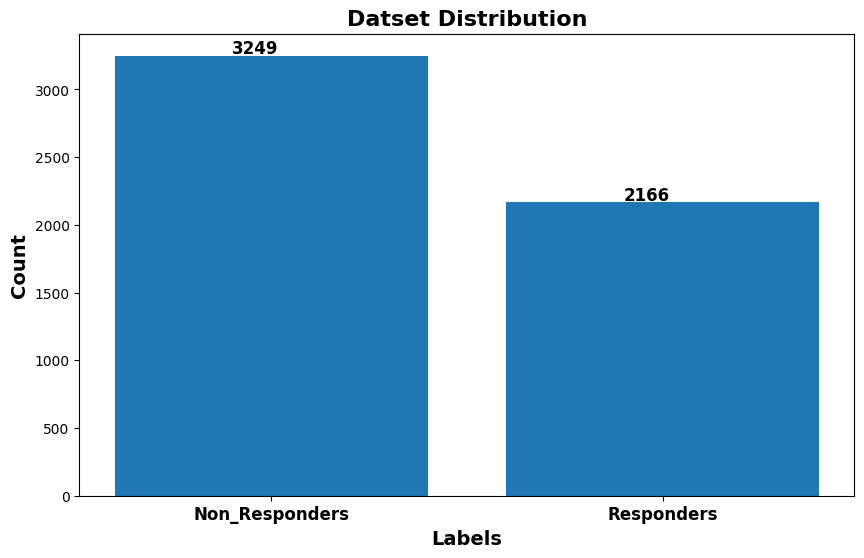

In [10]:
label_counts = df["label"].value_counts()

# Plotting the bar plot with count representation
fig, ax = plt.subplots(figsize=(10, 6)) 
bars = plt.bar(label_counts.index, label_counts.values, linewidth=1.5)

# Customize x-label and y-label size
plt.xlabel('Labels', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Customize x-tick labels size and make them bold
plt.xticks(fontsize=12, fontweight='bold')

# Increase space between bars and count numbers
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 15, str(count), fontsize=12, fontweight='bold')

# Add a border to the bars
for bar in bars:
    bar.set_linewidth(1.5)

# Title of the plot
plt.title('Datset Distribution', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

# Calculate the number of images for each class in the test set
test_size_percent = 0.1
num_responders_test = round(2166 * test_size_percent)  # Round to the nearest integer
num_non_responders_test = round(3249 * test_size_percent)  # Round to the nearest integer

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=test_size_percent, stratify=df['label'], random_state=42)

# Displaying the shapes of the resulting DataFrames
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Print the number of images in each class for the test set
print("Number of Responders in Test Set:", num_responders_test)
print("Number of Non_Responders in Test Set:", num_non_responders_test)


Train set shape: (4873, 2)
Test set shape: (542, 2)
Number of Responders in Test Set: 217
Number of Non_Responders in Test Set: 325


In [12]:
from sklearn.model_selection import StratifiedKFold

# Set up StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation sets
fold_train_dfs = []
fold_val_dfs = []

# Split the training set into 5 folds
for train_index, val_index in skf.split(train_df['path'], train_df['label']):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]
    
    # Append to the lists
    fold_train_dfs.append(train_fold)
    fold_val_dfs.append(val_fold)

# Print the number of images in each class for each fold
for fold, (train_fold, val_fold) in enumerate(zip(fold_train_dfs, fold_val_dfs), 1):
    print(f"Fold {fold} - Training Set Class Distribution:")
    print(train_fold['label'].value_counts())
    print(f"\nFold {fold} - Validation Set Class Distribution:")
    print(val_fold['label'].value_counts())
    print("\n" + "-"*40)


Fold 1 - Training Set Class Distribution:
label
Non_Responders    2339
Responders        1559
Name: count, dtype: int64

Fold 1 - Validation Set Class Distribution:
label
Non_Responders    585
Responders        390
Name: count, dtype: int64

----------------------------------------
Fold 2 - Training Set Class Distribution:
label
Non_Responders    2339
Responders        1559
Name: count, dtype: int64

Fold 2 - Validation Set Class Distribution:
label
Non_Responders    585
Responders        390
Name: count, dtype: int64

----------------------------------------
Fold 3 - Training Set Class Distribution:
label
Non_Responders    2339
Responders        1559
Name: count, dtype: int64

Fold 3 - Validation Set Class Distribution:
label
Non_Responders    585
Responders        390
Name: count, dtype: int64

----------------------------------------
Fold 4 - Training Set Class Distribution:
label
Non_Responders    2340
Responders        1559
Name: count, dtype: int64

Fold 4 - Validation Set Class 

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
from keras.applications import EfficientNetV2L
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense
from keras.models import Model
from keras.optimizers import Adam

# Define the input shape
input_shape = (224, 224, 3)

# Load the pre-trained EfficientNetV2L model
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global average pooling layer, BatchNormalization, and a dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add BatchNormalization
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [22]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      9,216 │ stem_activation[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │        128 │ block1a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 32)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      9,216 │ block1a_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │        128 │ block1b_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 32)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 112, 112,  │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 112, 112,  │        128 │ block1c_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 112, 112,  │          0 │ block1c_project_

 Total params: 117,753,249 (449.19 MB)

 Trainable params: 117,238,113 (447.23 MB)

 Non-trainable params: 515,136 (1.97 MB)

In [24]:
# Initialize EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Fold 1
Start Time: 2024-05-22 23:35:29
Found 3898 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 975 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 1272s 5s/step - accuracy: 0.6519 - loss: 0.6985 - val_accuracy: 0.7118 - val_loss: 0.5673
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8567 - loss: 0.3351 - val_accuracy: 0.8544 - val_loss: 0.3294
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9096 - loss: 0.2275 - val_accuracy: 0.8215 - val_loss: 0.3689
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9520 - loss: 0.1329 - val_accuracy: 0.6585 - val_loss: 0.9902
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9606 - loss: 0.1056 - val_accuracy: 0.9159 - val_loss: 0.2131
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9716 - loss: 0.0794 - val_accuracy: 0.8964 - val_loss: 0.2709
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9829 - loss: 0.0501 - val_accuracy: 0.9436 - val_loss: 0.1431
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9748 - loss: 0.0581 - val_accuracy: 0.83

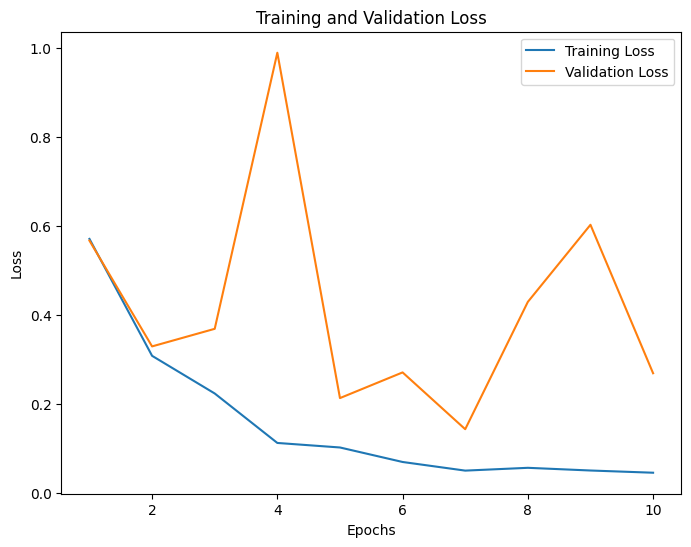

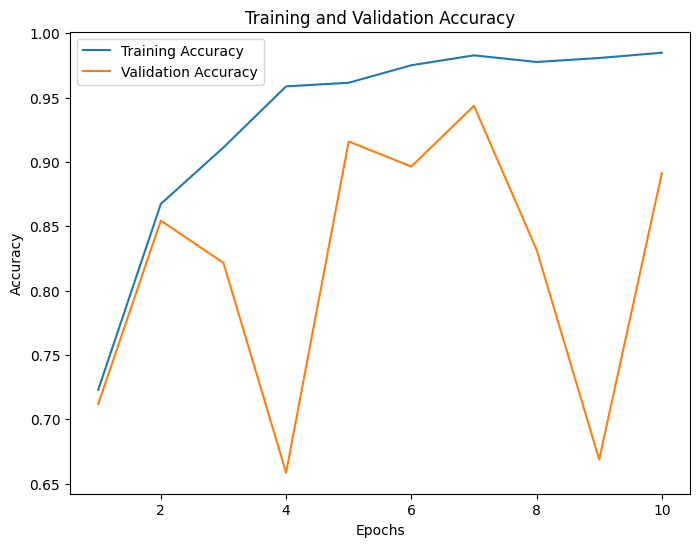

Fold 2
Start Time: 2024-05-23 00:17:54
Found 3898 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 975 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9717 - loss: 0.0863 - val_accuracy: 0.8821 - val_loss: 0.2618
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9803 - loss: 0.0620 - val_accuracy: 0.9641 - val_loss: 0.1013
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9811 - loss: 0.0566 - val_accuracy: 0.9456 - val_loss: 0.1291
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9870 - loss: 0.0389 - val_accuracy: 0.7918 - val_loss: 0.4524
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9935 - loss: 0.0172 - val_accuracy: 0.8482 - val_loss: 0.4106
End Time: 2024-05-23 00:29:42
Elapsed Time for Fold 2: 708.26 seconds

Training Loss: [0.08654019981622696, 0.050769247114658356, 0.054838478565216064, 0.04014424979686737, 0.02007518894970417]
Validation Loss: [0.26175862550735474, 0.10133585333824158, 0.12905652821063995, 0.4524029791355133, 0.41056767106056213]
Training Accuracy: [0.9715238809585571, 0.98152899

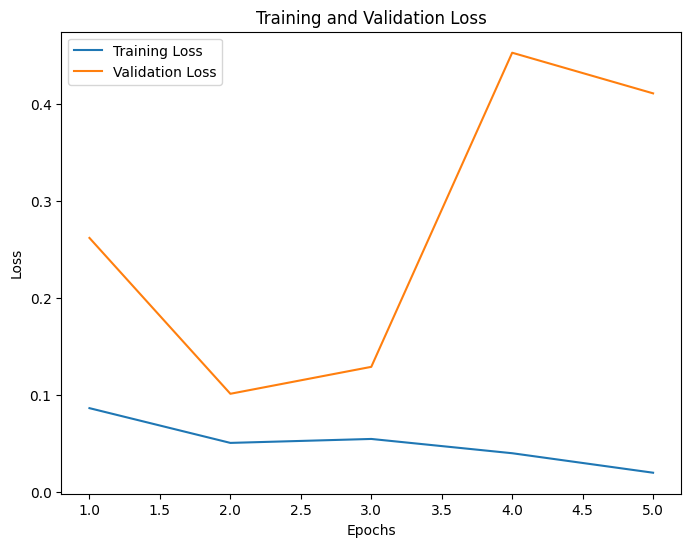

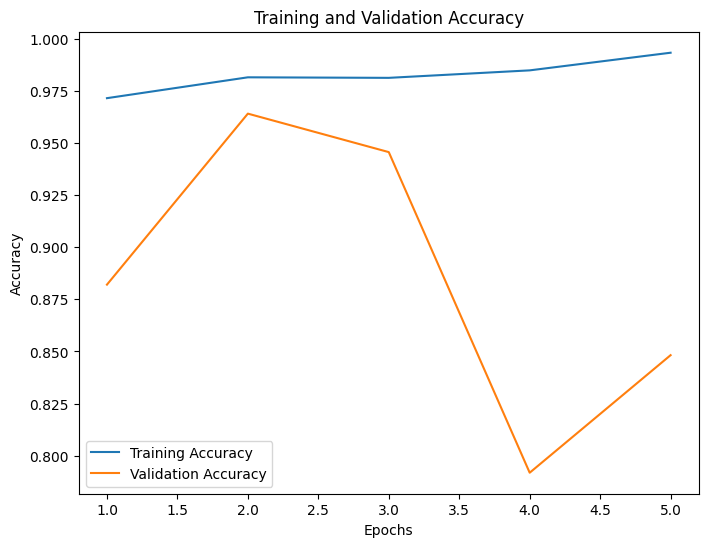

Fold 3
Start Time: 2024-05-23 00:29:43
Found 3898 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 975 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9711 - loss: 0.0794 - val_accuracy: 0.6974 - val_loss: 0.6726
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9838 - loss: 0.0468 - val_accuracy: 0.7456 - val_loss: 0.4884
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9891 - loss: 0.0301 - val_accuracy: 0.9590 - val_loss: 0.1427
End Time: 2024-05-23 00:36:49
Elapsed Time for Fold 3: 426.55 seconds

Training Loss: [0.07221073657274246, 0.03214652091264725, 0.034798797219991684]
Validation Loss: [0.6725982427597046, 0.4884072542190552, 0.14269065856933594]
Training Accuracy: [0.9751154184341431, 0.9881990551948547, 0.9881990551948547]
Validation Accuracy: [0.6974359154701233, 0.7456410527229309, 0.9589743614196777]


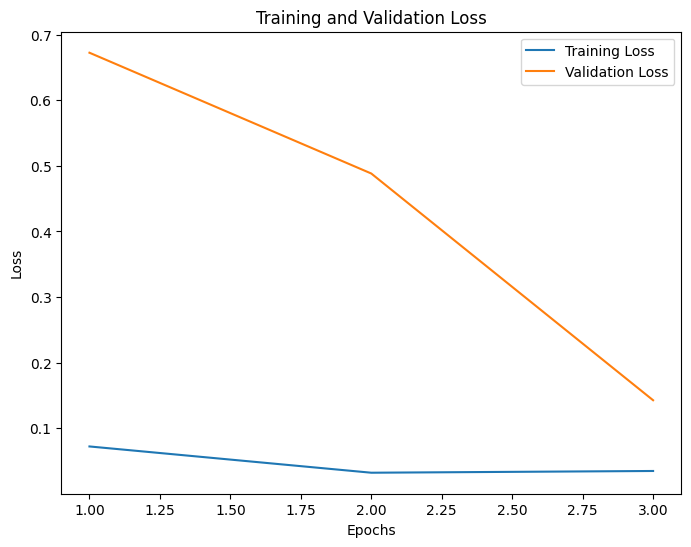

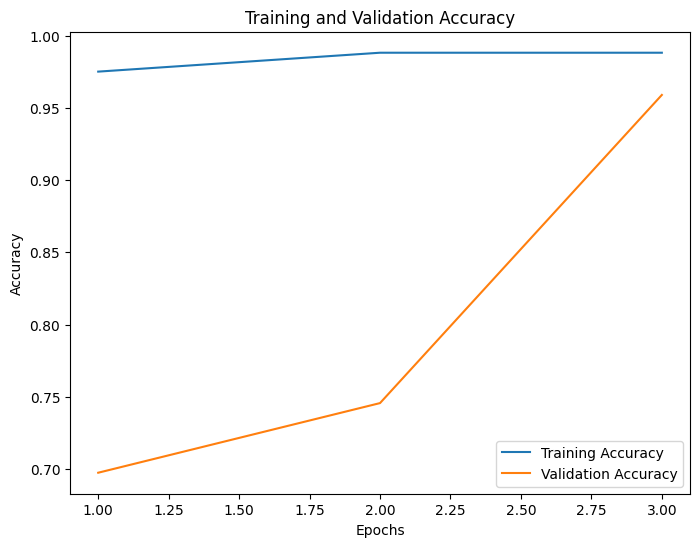

Fold 4
Start Time: 2024-05-23 00:36:50
Found 3899 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 974 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 584s 5s/step - accuracy: 0.9802 - loss: 0.0555 - val_accuracy: 0.9456 - val_loss: 0.1277
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9934 - loss: 0.0241 - val_accuracy: 0.9825 - val_loss: 0.0399
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9902 - loss: 0.0291 - val_accuracy: 0.8665 - val_loss: 0.3297
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9906 - loss: 0.0293 - val_accuracy: 0.9918 - val_loss: 0.0240
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9951 - loss: 0.0141 - val_accuracy: 0.9784 - val_loss: 0.0602
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.9805 - val_loss: 0.0541
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9989 - loss: 0.0046 - val_accuracy: 0.9702 - val_loss: 0.0860
End Time: 2024-05-23 01:00:46
Elapsed Time for Fold 4: 1435.93 seconds

Training Loss: [0.05232704058289528,

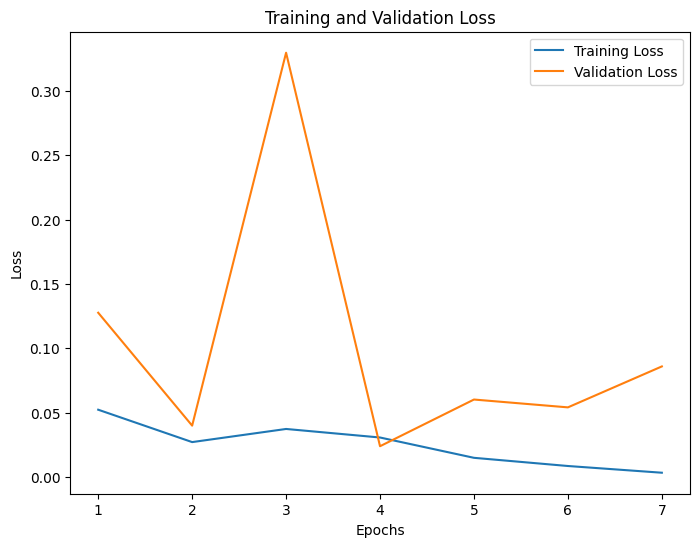

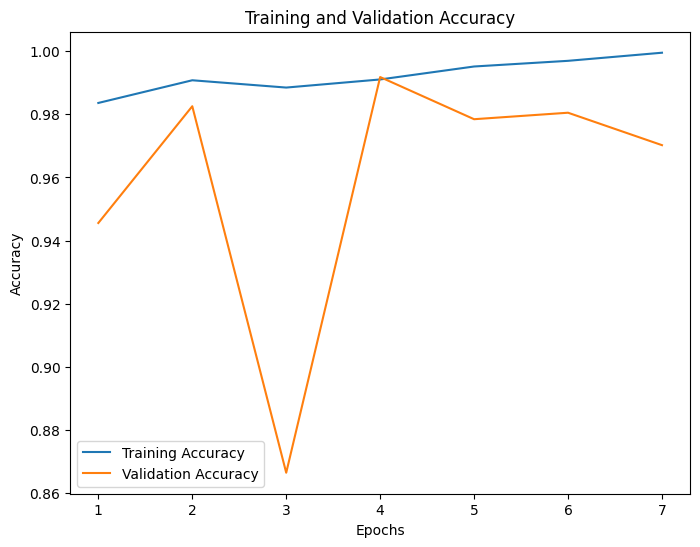

Fold 5
Start Time: 2024-05-23 01:00:46
Found 3899 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 974 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9914 - loss: 0.0211 - val_accuracy: 0.6684 - val_loss: 0.7486
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9899 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9956 - loss: 0.0165 - val_accuracy: 0.9651 - val_loss: 0.1062
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9961 - loss: 0.0134 - val_accuracy: 0.9671 - val_loss: 0.0862
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9917 - loss: 0.0220 - val_accuracy: 0.8111 - val_loss: 0.4456
End Time: 2024-05-23 01:12:36
Elapsed Time for Fold 5: 709.58 seconds

Training Loss: [0.02430502511560917, 0.02403011918067932, 0.023012610152363777, 0.015317561104893684, 0.017564645037055016]
Validation Loss: [0.7486288547515869, 0.004392605274915695, 0.10617905855178833, 0.08624134212732315, 0.4455835819244385]
Training Accuracy: [0.9915363192558289, 0.9917927

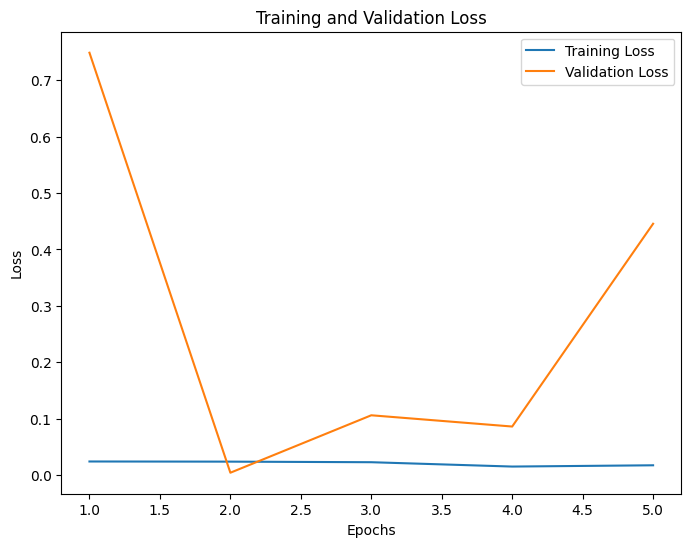

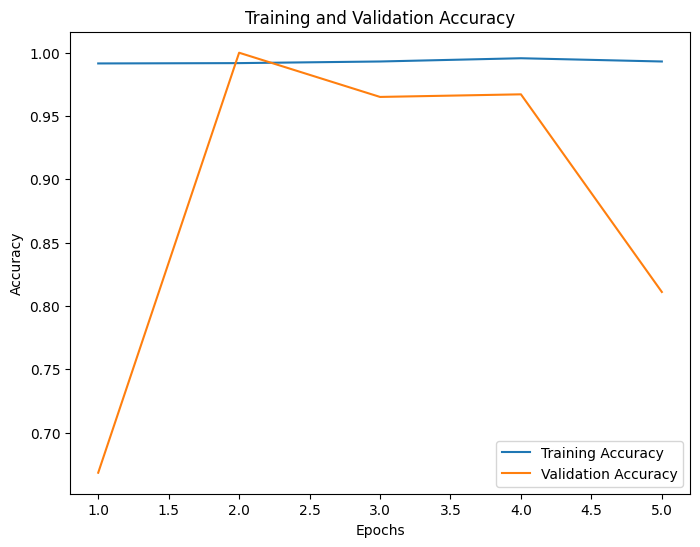

Total Training Time: 5824.86 seconds


In [25]:
# Number of epochs and batch size
epochs = 10
batch_size = 32

# Initialize lists to store loss and accuracy values
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize lists to store start and end times
all_start_times = []
all_end_times = []

# Loop through the folds and fit the model
for i in range(5):
    print("Fold", i + 1)

    # Record the start time for the current fold
    start_time = time.time()
    all_start_times.append(start_time)
    print("Start Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))

    # Get the current fold's training and validation sets
    fold_train = fold_train_dfs[i]
    fold_val = fold_val_dfs[i]

    # Training generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=fold_train,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='binary'
    )
    print("train_generator classes", train_generator.class_indices)

    # Validation generator
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=fold_val,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='binary'
    )
    print("val_generator classes", val_generator.class_indices)

    # Fit the model on the current fold's training and validation data
    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        validation_data=val_generator,
        callbacks=[early_stop]
    )

    # Record the end time for the current fold
    end_time = time.time()
    all_end_times.append(end_time)
    print("End Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time)))

    # Calculate and print the elapsed time for the current fold
    elapsed_time = end_time - start_time
    print("Elapsed Time for Fold {}: {:.2f} seconds\n".format(i + 1, elapsed_time))

    # Print the training and validation loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print("Training Loss:", train_loss)
    print("Validation Loss:", val_loss)
    print("Training Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)

    # Append the loss and accuracy values to the lists
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

    # Plot the training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(history.epoch) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, len(history.epoch) + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Calculate and print the total training time
total_training_time = sum(all_end_times) - sum(all_start_times)
print("Total Training Time: {:.2f} seconds".format(total_training_time))

In [26]:
# Calculate and print the average loss and accuracy
avg_train_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_train_loss]
avg_val_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_val_loss]
avg_train_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_train_acc]
avg_val_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_val_acc]

print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)
print("Average Training Accuracy:", avg_train_acc)
print("Average Validation Accuracy:", avg_val_acc)

Average Training Loss: [0.15876564607024193, 0.05047347284853458, 0.046385351568460464, 0.02492454558211778, 0.020845992118120195]
Average Validation Loss: [0.41844029128551485, 0.27102433145046234, 0.43456538518269855, 0.10309688986412116, 0.2782050885260105]
Average Training Accuracy: [0.9322986125946044, 0.982503867149353, 0.9838378429412842, 0.9921958105904716, 0.9930238485336303]
Average Validation Accuracy: [0.8193845987319947, 0.8863589882850647, 0.8006837765375773, 0.9593722479684013, 0.8823408722877503]


In [29]:
# Calculate and print the average loss and accuracy
mean_train_loss = sum(avg_train_loss) / len(avg_train_loss)
mean_val_loss = sum(avg_val_loss) / len(avg_val_loss)
mean_train_acc = sum(avg_train_acc) / len(avg_train_acc)
mean_val_acc = sum(avg_val_acc) / len(avg_val_acc)

print("Mean Training Loss:", mean_train_loss)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Training Accuracy:", mean_train_acc)
print("Mean Validation Accuracy:", mean_val_acc)


Mean Training Loss: 0.060279001637494986
Mean Validation Loss: 0.3010663972617615
Mean Training Accuracy: 0.9767719963618686
Mean Validation Accuracy: 0.8696280967621577


In [30]:
# Record start time
start_time = time.time()

# Setting the test set as the final evaluation set
evaluation_set = test_df

# Print the length of the evaluation set
print("Evaluation set length:", len(evaluation_set))

# Evaluate the model on the evaluation set
evaluation_generator = test_datagen.flow_from_dataframe(
    dataframe=evaluation_set,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    seed=1234,
    shuffle=False,
    class_mode='binary'
)
print("evaluation_generator classes", evaluation_generator.class_indices)

evaluation_loss, evaluation_accuracy = model.evaluate(evaluation_generator)

# Record end time
end_time = time.time()

# Calculate and print the time taken for evaluation
elapsed_time = end_time - start_time
print("Time taken for evaluation:", elapsed_time, "seconds")

print("Evaluation Loss:", evaluation_loss)
print("Evaluation Accuracy:", evaluation_accuracy)

Evaluation set length: 542
Found 542 validated image filenames belonging to 2 classes.
evaluation_generator classes {'Non_Responders': 0, 'Responders': 1}


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - accuracy: 0.9668 - loss: 0.0975
Time taken for evaluation: 5.483733177185059 seconds
Evaluation Loss: 0.08541488647460938
Evaluation Accuracy: 0.9704797267913818


In [31]:
# After training, save the model
model.save('MDD_EfficientNetV2L.h5')
print("Model saved successfully")

Model saved successfully


### Performanc Evaluation

In [32]:
# Predict on the evaluation set
evaluation_predictions = model.predict(evaluation_generator)
evaluation_pred_classes = (evaluation_predictions > 0.5).astype(int)  

# Get true labels
true_labels = evaluation_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, evaluation_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)



# Calculate classification report
class_report = classification_report(true_labels, evaluation_pred_classes)
print("Classification Report:")
print(class_report)


17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step 
Confusion Matrix:
[[316   9]
 [  7 210]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       325
           1       0.96      0.97      0.96       217

    accuracy                           0.97       542
   macro avg       0.97      0.97      0.97       542
weighted avg       0.97      0.97      0.97       542



In [33]:
# Calculate classification report
class_report = classification_report(true_labels, evaluation_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       325
           1       0.96      0.97      0.96       217

    accuracy                           0.97       542
   macro avg       0.97      0.97      0.97       542
weighted avg       0.97      0.97      0.97       542



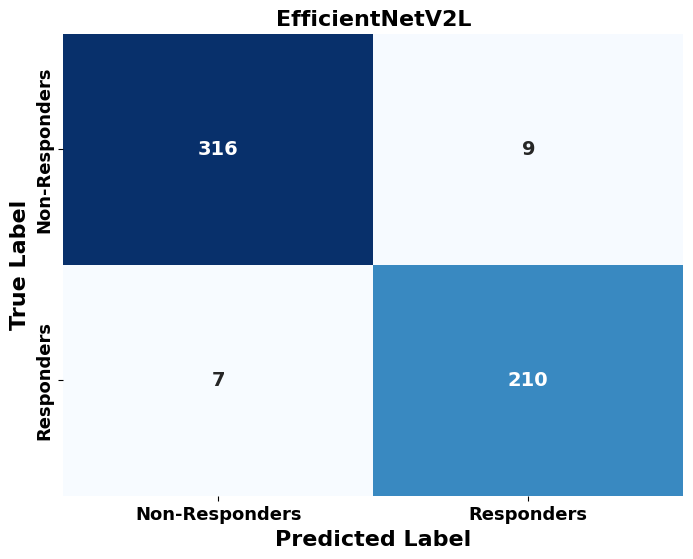

In [44]:
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Increase font size for true and predicted labels
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"size": 14, "weight": "bold"})  # Increase font size and weight for values
    
    # Increase font size and make class labels bold
    ax.set_xticklabels(class_names, fontsize=13, weight='bold')
    ax.set_yticklabels(class_names, fontsize=13, weight='bold')
    
    plt.xlabel('Predicted Label', fontsize=16, weight='bold')  
    plt.ylabel('True Label', fontsize=16, weight='bold')  # Increase font size and weight for y label
    plt.title('EfficientNetV2L', fontsize=16, weight='bold')  # Increase font size and weight for title
    plt.show()

# confusion matrix (conf_matrix) and class names
class_names = ['Non-Responders', 'Responders']
plot_confusion_matrix(conf_matrix, class_names)

In [35]:
print(evaluation_generator.classes)

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

In [36]:
# Get true labels
true_labels = evaluation_generator.classes

# Predict on the evaluation set
evaluation_predictions = model.predict(evaluation_generator)
predicted_labels = (evaluation_predictions > 0.5).astype(int)

# Initialize counters for correct and incorrect predictions
correct_predictions = 0
incorrect_predictions = 0

# Iterate over all predictions
for i in range(len(true_labels)):
    if true_labels[i] == predicted_labels[i]:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / (correct_predictions + incorrect_predictions)

# Print the results
print("Correct Predictions:", correct_predictions)
print("Incorrect Predictions:", incorrect_predictions)
print("Accuracy:", accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step
Correct Predictions: 526
Incorrect Predictions: 16
Accuracy: 0.9704797047970479


In [37]:
# confusion matrix (conf_matrix) and class names
class_names = ['Non_Responders', 'Responders']

# Print confusion matrix with counts
for i in range(len(class_names)):
    print(f"\nClass: {i} ({class_names[i]})")
    true_positives = conf_matrix[i, i]
    true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    print(f"True Positives (TP): {true_positives}")
    print(f"True Negatives (TN): {true_negatives}")
    print(f"False Positives (FP): {false_positives}")
    print(f"False Negatives (FN): {false_negatives}")
    print("====================")

# calculate and print overall metrics
overall_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

print("\nOverall Metrics:")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Class: 0 (Non_Responders)
True Positives (TP): 316
True Negatives (TN): 210
False Positives (FP): 7
False Negatives (FN): 9

Class: 1 (Responders)
True Positives (TP): 210
True Negatives (TN): 316
False Positives (FP): 9
False Negatives (FN): 7

Overall Metrics:
Overall Accuracy: 0.9704797047970479
Precision: [0.97832817 0.95890411]
Recall: [0.97230769 0.96774194]


In [42]:
# confusion matrix (conf_matrix) and class names
class_names = ['Non_Responders', 'Responders']

# Print class-specific metrics
for i in range(len(class_names)):
    precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i]) if np.sum(conf_matrix[:, i]) != 0 else 0
    recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :]) if np.sum(conf_matrix[i, :]) != 0 else 0
    specificity = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(conf_matrix) - np.sum(conf_matrix[:, i]) - np.sum(conf_matrix[i, :]) + conf_matrix[i, i])
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    print(f"\nClass: {class_names[i]}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print("====================")



Class: Non_Responders
Precision: 0.9783
Recall: 0.9723
Specificity: 1.0000
F1-score: 0.9753

Class: Responders
Precision: 0.9589
Recall: 0.9677
Specificity: 1.0000
F1-score: 0.9633


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step


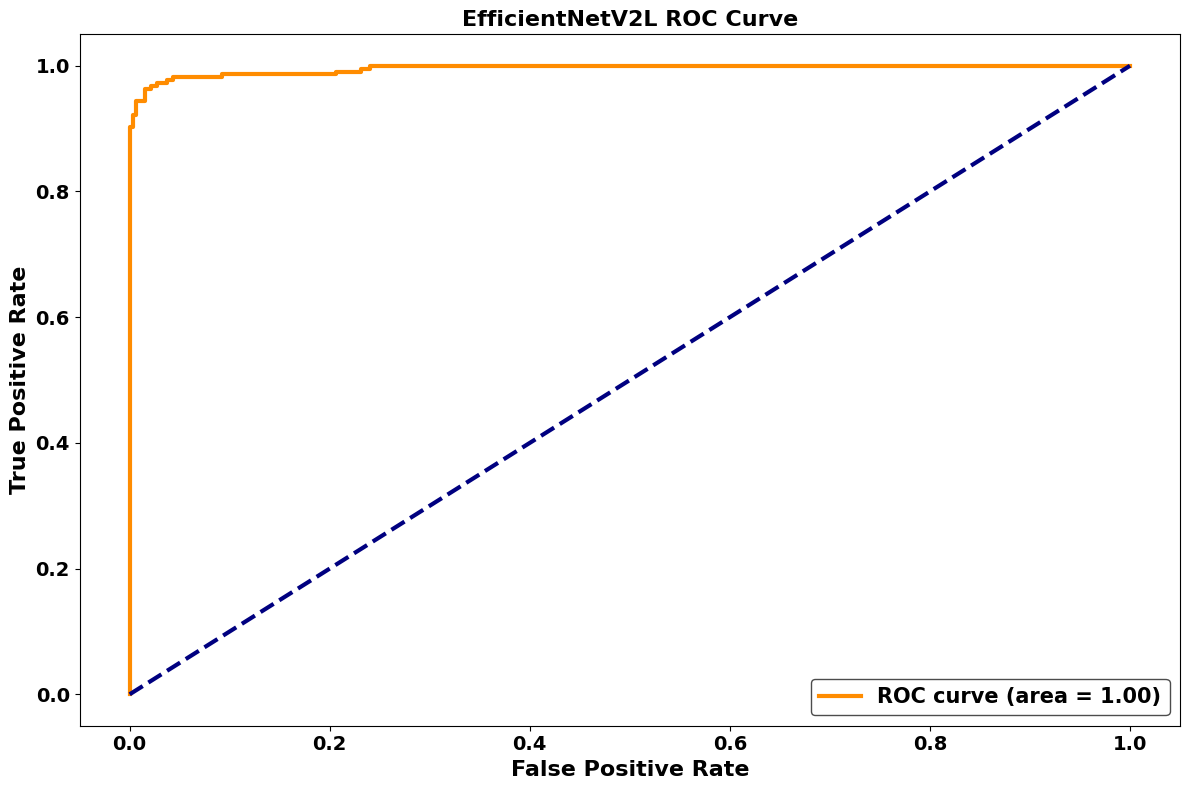

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming true_labels and predicted_probabilities are already defined
true_labels = evaluation_generator.classes
predicted_probabilities = model.predict(evaluation_generator)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate', fontsize=16, weight='bold')  # Adjust x label properties
plt.ylabel('True Positive Rate', fontsize=16, weight='bold')  # Adjust y label properties
plt.title('EfficientNetV2L ROC Curve', fontsize=16, weight='bold')  # Adjust title properties
plt.xticks(fontsize=14, fontweight='bold')  # Increase font size of x ticks
plt.yticks(fontsize=14, fontweight='bold')  # Increase font size of y ticks

# Make text inside legend bold and increase size
legend = plt.legend(loc='lower right', fontsize=15, fancybox=True, framealpha=0.7, edgecolor='black')
for text in legend.get_texts():
    text.set_weight('bold')

plt.tight_layout()

# # Save plot to local system
# plt.savefig('MDD_Xception_ROC.png')

plt.show()


In [41]:
from tensorflow.keras.models import load_model

# Load the saved CNN model
loaded_model = load_model('/kaggle/working/MDD_EfficientNetV2L.h5')

# evaluation set
evaluation_set = test_df

# Evaluate the loaded model on the evaluation set
evaluation_generator = test_datagen.flow_from_dataframe(
    dataframe=evaluation_set,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    seed=1234,
    shuffle=False,
    class_mode='binary'
)

# Evaluate the model
evaluation_loss, evaluation_accuracy = loaded_model.evaluate(evaluation_generator)

print("Evaluation Loss:", evaluation_loss)
print("Evaluation Accuracy:", evaluation_accuracy)

Found 542 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 904ms/step - accuracy: 0.9668 - loss: 0.0975
Evaluation Loss: 0.08541488647460938
Evaluation Accuracy: 0.9704797267913818
